**This notebook is an exercise in the [Computer Vision](https://www.kaggle.com/learn/computer-vision) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/custom-convnets).**

---


# Introduction #

In these exercises, you'll build a custom convnet with performance competitive to the VGG16 model from Lesson 1.

Get started by running the code cell below.

In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex5 import *

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


# Design a Convnet #

Let's design a convolutional network with a block architecture like we saw in the tutorial. The model from the example had three blocks, each with a single convolutional layer. Its performance on the "Car or Truck" problem was okay, but far from what the pretrained VGG16 could achieve. It might be that our simple network lacks the ability to extract sufficiently complex features. We could try improving the model either by adding more blocks or by adding convolutions to the blocks we have.

Let's go with the second approach. We'll keep the three block structure, but increase the number of `Conv2D` layer in the second block to two, and in the third block to three.

<figure>
<!-- <img src="./images/2-convmodel-2.png" width="250" alt="Diagram of a convolutional model."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Vko6nCK.png" width="250" alt="Diagram of a convolutional model.">
</figure>

# 1) Define Model #

Given the diagram above, complete the model by defining the layers of the third block.

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape=[128, 128, 3]),
    layers.MaxPool2D(),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    

    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

# Check your answer
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [ ]:
# Lines below will give you a hint or solution code
#q_1.hint()
#q_1.solution()

# 2) Compile #

To prepare for training, compile the model with an appropriate loss and accuracy metric for the "Car or Truck" dataset.

In [4]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# Check your answer
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)
q_2.assert_check_passed()

In [ ]:
# Lines below will give you a hint or solution code
#q_2.hint()
#q_2.solution()

Finally, let's test the performance of this new model. First run this cell to fit the model to the training set.

In [5]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

Epoch 1/50
80/80 [==============================] - 49s 488ms/step - loss: 0.6771 - binary_accuracy: 0.5822 - val_loss: 0.6677 - val_binary_accuracy: 0.5785
Epoch 2/50
80/80 [==============================] - 4s 54ms/step - loss: 0.6655 - binary_accuracy: 0.5835 - val_loss: 0.6545 - val_binary_accuracy: 0.6151
Epoch 3/50
80/80 [==============================] - 4s 53ms/step - loss: 0.6603 - binary_accuracy: 0.5980 - val_loss: 0.6517 - val_binary_accuracy: 0.5791
Epoch 4/50
80/80 [==============================] - 4s 54ms/step - loss: 0.6532 - binary_accuracy: 0.5792 - val_loss: 0.6438 - val_binary_accuracy: 0.5801
Epoch 5/50
80/80 [==============================] - 4s 53ms/step - loss: 0.6456 - binary_accuracy: 0.6086 - val_loss: 0.6325 - val_binary_accuracy: 0.6339
Epoch 6/50
80/80 [==============================] - 4s 54ms/step - loss: 0.6327 - binary_accuracy: 0.6347 - val_loss: 0.6210 - val_binary_accuracy: 0.6454
Epoch 7/50
80/80 [==============================] - 4s 54ms/step - l

And now run the cell below to plot the loss and metric curves for this training run.

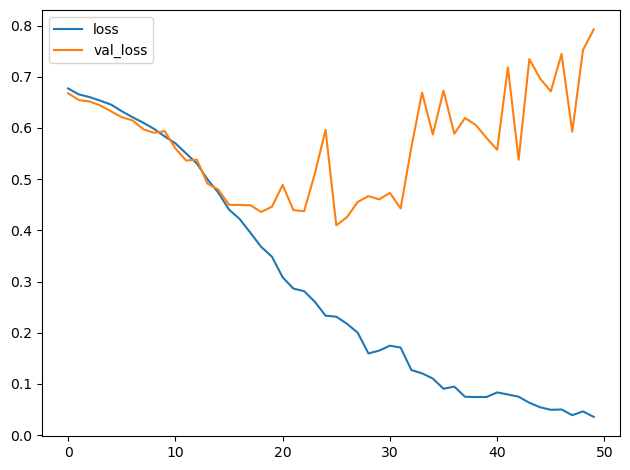

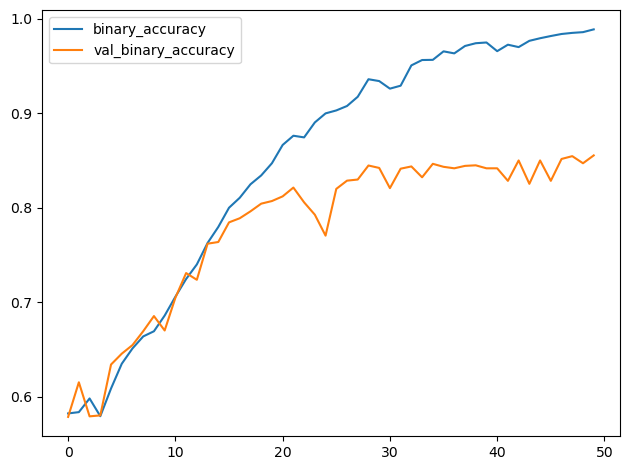

In [6]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

# 3) Train the Model #

How would you interpret these training curves? Did this model improve upon the model from the tutorial?

In [7]:
# View the solution (Run this code cell to receive credit!)
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 


The learning curves for the model from the tutorial diverged fairly rapidly. This would indicate that it was prone to overfitting and in need of some regularization. The additional layer in our new model would make it even more prone to overfitting. However, adding some regularization with the `Dropout` layer helped prevent this. These changes improved the validation accuracy of the model by several points.


# Conclusion #

These exercises showed you how to design a custom convolutional network to solve a specific classification problem. Though most models these days will be built on top of a pretrained base, it certain circumstances a smaller custom convnet might still be preferable -- such as with a smaller or unusual dataset or when computing resources are very limited. As you saw here, for certain problems they can perform just as well as a pretrained model.

# Keep Going #

Continue on to [**Lesson 6**](https://www.kaggle.com/ryanholbrook/data-augmentation), where you'll learn a widely-used technique that can give a boost to your training data: **data augmentation**.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/computer-vision/discussion) to chat with other learners.*